# Chapter 7: Feature Engineering

Accompanying code for chapter 7 of the book [Applied Data Science in Tourism: Interdisciplinary Approches, Methodologies and Applications](http://datascience-in-tourism.com/).

This notebook plus associated data is available online at https://github.com/DrDub/artfeateng/tourism.

## MIT License

Copyright 2021 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<a href="https://colab.research.google.com/github/DrDub/artfeateng/blob/master/tourism/FeatureEngineeringAirBnBVancouver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OS Setup

PySpark uses an embedded Java virtual machine (JVM). If you need to set a specific JVM, uncomment here changing to the path of the JVM

Details: The error message says something in the line of 
_java.lang.reflect.InaccessibleObjectException: Unable to make private java.nio.DirectByteBuffer(long,int) accessible_ see this stack overflow post [Spark does't run in Windows anymore](https://stackoverflow.com/questions/66904801/spark-doest-run-in-windows-anymore) for background.


In [1]:
import os

# os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

This is the set-up for Google Collab. Skip this cell if running locally.

In [ ]:
!wget http://artoffeatureengineering.com/tourism/listings-cleaned2.csv
!wget http://artoffeatureengineering.com/tourism/stops.tsv
!pip install pyspark shap

## Imports

In [2]:
import math

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct
from pyspark.sql.types import IntegerType, ArrayType, StringType, DoubleType, BooleanType

from pyspark.ml import Pipeline, UnaryTransformer
from pyspark.ml.feature import VectorAssembler, CountVectorizer, StringIndexer, Interaction
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.linalg import VectorUDT

from pyspark.mllib.evaluation import RegressionMetrics

from IPython.display import HTML, display

## Setup

In [3]:
spark = SparkSession.builder.appName('FeatureEngineeringAirBnB').getOrCreate()

### Loading the data

This data was downloaded from [InsideAirBnB.com](http://data.insideairbnb.com/canada/bc/vancouver/2021-02-09/data/listings.csv.gz), an excelent website created by [Murray Cox](http://insideairbnb.com/about.html).

The original data was loaded on a spreadsheet program and the text columns were filtered out as NLP is not the focus of this chapter.

By using "infer schema" Spark will do a two-pass inference of basic data fields.

In [4]:
alldata = spark.read.csv("listings-cleaned2.csv", inferSchema=True, header=True)

We can see how well the inference worked.

In [5]:
alldata.printSchema()

root
 |-- id: integer (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_count: integer (nullable = true)
 |-- host_total_listings_count: integer (nullable = true)
 |-- host_verifications: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- neighbourhood_group_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nu

In [6]:
len(alldata.columns)

45

There are many columns with usable types. Others seem to be assigned ```string``` when a more suitable type might work (e.g., ```date``` for ```host_since```). But we need to do some EDA on them and for that we need to keep some held-out data to avoid basing our intuitions in the whole dataset (which will not leave additional data to test whether the intuitions are correct).

### Data split

We are using 40% of the data for testing and 30% of the training data as development test:

In [7]:
(fulldataset, testData) = alldata.randomSplit([0.8, 0.2], seed=42)
(dataset, devset)   = fulldataset.randomSplit([0.6, 0.4], seed=42)

Let us now peek at the training data to gain some insights.

In [8]:
dataset.show(vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                           | 13358                                                                                              

The string fields will need special processing before we can make sense of them.

Some of them, such as ```property_type``` seem to have categorical data (specific strings that belong to a small set), we will have to transform them to indices or vector of boolean features (one-hot-encoded).

Others are duplicates of the same information (e.g., "neighbourhood", "neighbourhood_cleansed" and "neighbourhood_group_cleansed"). For such, we will select the one with the highest quality to add to the feature vector.

Finally, ```amenities``` and ```host_verifications``` are a set-based features, represented as a strings. That will require quite a bit of processing.

### Transformers


Before analysing how these columns behave with respect to our target value (```price```), let us handle the categorical data encoding it to indexes. This is is accomplished in pyspark by using aptly named ```Transformer```s named _indexers_ (the name is unrelated to deep learning transformers).

In pyspark, we can define different transformers and apply them all together as part of a ```Pipeline```. We will be recording the different transformers we will be using in the ```stages``` list defined below.

In [9]:
stages = list()

### Indexing Categorical Features

For this case study, these three key features will be considered: which neighbourhood the property is in, the type of property and the type of room.

Spark has ```StringIndexer```es that are very strict. We will relax them with an "other" category and leave unseen categories and rare categories as other.

In [10]:
dataset.groupBy("neighbourhood_cleansed").\
  count().\
  sort("count").\
  show(999, truncate=False)

+------------------------+-----+
|neighbourhood_cleansed  |count|
+------------------------+-----+
|Strathcona              |16   |
|Kerrisdale              |19   |
|Victoria-Fraserview     |21   |
|Killarney               |27   |
|Arbutus Ridge           |28   |
|Shaughnessy             |31   |
|South Cambie            |31   |
|West Point Grey         |35   |
|Oakridge                |45   |
|Sunset                  |46   |
|Marpole                 |58   |
|Dunbar Southlands       |64   |
|Fairview                |68   |
|Renfrew-Collingwood     |68   |
|Hastings-Sunrise        |84   |
|Grandview-Woodland      |97   |
|Riley Park              |105  |
|Downtown Eastside       |112  |
|Mount Pleasant          |142  |
|Kensington-Cedar Cottage|143  |
|West End                |172  |
|Kitsilano               |191  |
|Downtown                |564  |
+------------------------+-----+



In [11]:
neighbourhood_reduced = set([ p['neighbourhood_cleansed'] \
                             for p in dataset.groupBy("neighbourhood_cleansed").\
                               count().sort("count").toLocalIterator() \
                             if p['count'] > 50])
neighbourhood_reduced

{'Downtown',
 'Downtown Eastside',
 'Dunbar Southlands',
 'Fairview',
 'Grandview-Woodland',
 'Hastings-Sunrise',
 'Kensington-Cedar Cottage',
 'Kitsilano',
 'Marpole',
 'Mount Pleasant',
 'Renfrew-Collingwood',
 'Riley Park',
 'West End'}

In [12]:
class SetReducer(UnaryTransformer):
    def __init__(self, valid_set, other_category):
        super(UnaryTransformer, self).__init__()
        self.valid_set = valid_set
        self.other_category = other_category

    def createTransformFunc(self):
        return lambda x: x if x in self.valid_set else self.other_category
    
    def outputDataType(self):
        return StringType()

    def validateInputType(self, inputType):
        assert inputType == StringType(), f'Expected StringType() and found {inputType}'


neighbourhood_reducer = SetReducer(neighbourhood_reduced, "OTHER"). \
  setInputCol('neighbourhood_cleansed'). \
  setOutputCol('neighbourhood_reduced')    

In [13]:
neighbourhood_reducer.transform(dataset). \
  groupBy("neighbourhood_reduced"). \
    count(). \
    sort("count"). \
    show(999, truncate=False)
stages.append(neighbourhood_reducer)

+------------------------+-----+
|neighbourhood_reduced   |count|
+------------------------+-----+
|Marpole                 |58   |
|Dunbar Southlands       |64   |
|Renfrew-Collingwood     |68   |
|Fairview                |68   |
|Hastings-Sunrise        |84   |
|Grandview-Woodland      |97   |
|Riley Park              |105  |
|Downtown Eastside       |112  |
|Mount Pleasant          |142  |
|Kensington-Cedar Cottage|143  |
|West End                |172  |
|Kitsilano               |191  |
|OTHER                   |299  |
|Downtown                |564  |
+------------------------+-----+



In [14]:
dataset.groupBy("property_type").\
  count().\
  sort("count").\
  show(999, truncate=False)

+---------------------------------+-----+
|property_type                    |count|
+---------------------------------+-----+
|Camper/RV                        |1    |
|Entire timeshare                 |1    |
|Entire cabin                     |1    |
|Shared room in loft              |1    |
|Private room in boat             |1    |
|Boat                             |1    |
|Private room in hostel           |1    |
|Private room in loft             |1    |
|Entire floor                     |1    |
|Entire cottage                   |1    |
|Entire place                     |2    |
|Room in bed and breakfast        |2    |
|Private room in bungalow         |3    |
|Room in hotel                    |3    |
|Shared room in house             |3    |
|Tiny house                       |3    |
|Shared room in apartment         |3    |
|Entire villa                     |5    |
|Room in aparthotel               |5    |
|Private room in guesthouse       |6    |
|Private room in bed and breakfast

In [15]:
property_reduced = set([ p['property_type'] \
                             for p in dataset.groupBy("property_type").\
                               count().sort("count").toLocalIterator() \
                             if p['count'] > 50])
property_reduced

{'Entire apartment',
 'Entire condominium',
 'Entire guest suite',
 'Entire house',
 'Entire loft',
 'Private room in apartment',
 'Private room in house'}

In [16]:
property_reducer = SetReducer(property_reduced, "OTHER"). \
  setInputCol('property_type'). \
  setOutputCol('property_reduced')

property_reducer.transform(dataset). \
  groupBy("property_reduced"). \
    count(). \
    sort("count"). \
    show(999, truncate=False)
stages.append(property_reducer)

+-------------------------+-----+
|property_reduced         |count|
+-------------------------+-----+
|Entire loft              |57   |
|Private room in apartment|94   |
|OTHER                    |264  |
|Entire guest suite       |266  |
|Private room in house    |278  |
|Entire house             |317  |
|Entire condominium       |389  |
|Entire apartment         |502  |
+-------------------------+-----+



In [17]:
dataset.groupBy("room_type").\
  count().\
  sort("count").\
  show(999, truncate=False)

+---------------+-----+
|room_type      |count|
+---------------+-----+
|Hotel room     |2    |
|Shared room    |7    |
|Private room   |486  |
|Entire home/apt|1672 |
+---------------+-----+



In [18]:
room_reduced = set([ p['room_type'] \
                             for p in dataset.groupBy("room_type").\
                               count().sort("count").toLocalIterator() \
                             if p['count'] > 50])
room_reduced

{'Entire home/apt', 'Private room'}

In [19]:
room_reducer = SetReducer(room_reduced, "OTHER"). \
  setInputCol('room_type'). \
  setOutputCol('room_reduced')

room_reducer.transform(dataset). \
  groupBy("room_reduced"). \
    count(). \
    sort("count"). \
    show(999, truncate=False)
stages.append(room_reducer)

+---------------+-----+
|room_reduced   |count|
+---------------+-----+
|OTHER          |9    |
|Private room   |486  |
|Entire home/apt|1672 |
+---------------+-----+



Once the strings have been reduced with the "OTHER" category, we can feed them into the Spark's indexer. The indexers will throw an error if they find an unseen string (which will not happen as anything unseen will be marked as "OTHER").

In [20]:
n_indexer = StringIndexer(inputCol="neighbourhood_reduced", outputCol="neighbourhood_indexed")
fitted_n_indexer = n_indexer.fit(neighbourhood_reducer.transform(dataset))
stages.append(fitted_n_indexer)

p_indexer = StringIndexer(inputCol="property_reduced", outputCol="property_indexed")
fitted_p_indexer = p_indexer.fit(property_reducer.transform(dataset))
stages.append(fitted_p_indexer)

r_indexer = StringIndexer(inputCol="room_reduced", outputCol="room_indexed")
fitted_r_indexer = r_indexer.fit(room_reducer.transform(dataset))
stages.append(fitted_r_indexer)

In [21]:
print(len(fitted_n_indexer.labels))
fitted_n_indexer.labels

14


['Downtown',
 'OTHER',
 'Kitsilano',
 'West End',
 'Kensington-Cedar Cottage',
 'Mount Pleasant',
 'Downtown Eastside',
 'Riley Park',
 'Grandview-Woodland',
 'Hastings-Sunrise',
 'Fairview',
 'Renfrew-Collingwood',
 'Dunbar Southlands',
 'Marpole']

In [22]:
print(len(fitted_p_indexer.labels))
fitted_p_indexer.labels

8


['Entire apartment',
 'Entire condominium',
 'Entire house',
 'Private room in house',
 'Entire guest suite',
 'OTHER',
 'Private room in apartment',
 'Entire loft']

In [23]:
print(len(fitted_r_indexer.labels))
fitted_r_indexer.labels

3


['Entire home/apt', 'Private room', 'OTHER']

We can instantiate a pipeline to see the transformed output.

In [24]:
pipeline = Pipeline(stages=stages)
pipeline.fit(dataset).transform(dataset).show(vertical=True)

-RECORD 0------------------------------------------------------------
 id                                           | 13358                
 host_since                                   | 2009/11/07           
 host_location                                | Vancouver, Britis... 
 host_response_time                           | within a day         
 host_response_rate                           | 0.71                 
 host_acceptance_rate                         | 0.71                 
 host_is_superhost                            | t                    
 host_neighbourhood                           | Downtown Vancouver   
 host_listings_count                          | 1                    
 host_total_listings_count                    | 1                    
 host_verifications                           | ['email', 'phone'... 
 host_has_profile_pic                         | f                    
 host_identity_verified                       | t                    
 neighbourhood      

### Set features: Amenities and Host Verifications

Once we have dealt with the categorical features, we can address the set-based columns. Let us take a look at them.

In [25]:
dataset.select("amenities").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|amenities                                                                                                                                                                                        

We want to transform them into multiple columns reusing the machinery in MLlib for NLP.

In [26]:
class FieldSplitter(UnaryTransformer):
    
    def createTransformFunc(self):
        def f(x):
            if x is None:
                return []
            l = x.split("', '")
            if len(l) > 1:
                l[0] = l[0][2:]
                l[-1] = l[-1][:-2]
            return l
        return f
    
    def outputDataType(self):
        return ArrayType(StringType())

    def validateInputType(self, inputType):
        assert inputType == StringType(), f'Expected StringType() and found {inputType}'
        
amenities_splitter = FieldSplitter(). \
  setInputCol('amenities'). \
  setOutputCol('amenities_array')

amenities_splitter.transform(dataset).show(vertical=True, truncate=False)
stages.append(amenities_splitter)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                           | 13358                                                                                              

In [27]:
verifications_splitter = FieldSplitter(). \
  setInputCol('host_verifications'). \
  setOutputCol('verifications_array')

verifications_splitter.transform(dataset).show(vertical=True, truncate=False)
stages.append(verifications_splitter)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                           | 13358                                                                                              

Now we can use a vectorizer to transform the arrays of strings to arrays of indexes.

In [28]:
cv_amenities = CountVectorizer(inputCol="amenities_array", outputCol="amenities_vector", 
                               vocabSize=20, minDF=2.0)
fitted_amenities = cv_amenities.fit(amenities_splitter.transform(dataset))
stages.append(fitted_amenities)

cv_verifications = CountVectorizer(inputCol="verifications_array", outputCol="verifications_vector", 
                                   vocabSize=5, minDF=2.0)
fitted_verifications = cv_verifications.fit(verifications_splitter.transform(dataset))
stages.append(fitted_verifications)

We keep the number of amenities and verifications under control by setting the vocabulary size.

In [29]:
print(len(fitted_amenities.vocabulary))
fitted_amenities.vocabulary

20


['Wifi',
 'Heating',
 'Smoke alarm',
 'Essentials',
 'Kitchen',
 'Hangers',
 'Long term stays allowed',
 'Washer',
 'Dryer',
 'Hair dryer',
 'TV',
 'Dedicated workspace',
 'Hot water',
 'Shampoo',
 'Iron',
 'Carbon monoxide alarm',
 'Dishes and silverware',
 'Fire extinguisher',
 'Refrigerator',
 'Cooking basics']

We can now build a pipeline to see the vectorizers in place.

In [30]:
pipeline = Pipeline(stages=stages)
pipeline.fit(dataset).transform(dataset).show(vertical=True)

-RECORD 0------------------------------------------------------------
 id                                           | 13358                
 host_since                                   | 2009/11/07           
 host_location                                | Vancouver, Britis... 
 host_response_time                           | within a day         
 host_response_rate                           | 0.71                 
 host_acceptance_rate                         | 0.71                 
 host_is_superhost                            | t                    
 host_neighbourhood                           | Downtown Vancouver   
 host_listings_count                          | 1                    
 host_total_listings_count                    | 1                    
 host_verifications                           | ['email', 'phone'... 
 host_has_profile_pic                         | f                    
 host_identity_verified                       | t                    
 neighbourhood      

### Decomposing complex features: host_since

Finally, we will deal with the date in ```host_since``` by changing the ```string``` to an ```int``` by keeping only the years.

In [31]:
class YearKeeper(UnaryTransformer):
    
    def createTransformFunc(self):
        def keep_year(s):
            if type(s) is str and len(s)>4:
                return int(s.split("/")[0])
            return None
        return keep_year
    
    def outputDataType(self):
        return IntegerType()

    def validateInputType(self, inputType):
        assert inputType == StringType(), f'Expected StringType() and found {inputType}'
        
year_keeper = YearKeeper(). \
  setInputCol('host_since'). \
  setOutputCol('since_year')

year_keeper.transform(dataset).show(vertical=True, truncate=False)
stages.append(year_keeper)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                           | 13358                                                                                              

## EDA

We will now plot rows against target of our dataset transformed as we have so far.

In [32]:
pipeline = Pipeline(stages=stages)
df = pipeline.fit(dataset).transform(dataset)

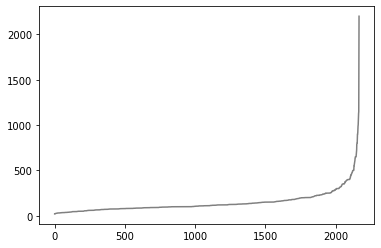

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

prices = [ p['price']  for p in df.select("price").toLocalIterator() ]

prices = sorted(prices)

plt.plot(prices, label="prices", color='gray')

This curve can profit from flattening using a log to better understand it.

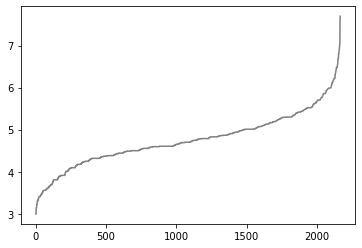

In [34]:
prices = list(map(math.log, prices))

plt.plot(prices, label="prices", color='gray')

In [35]:
class LogTransformer(UnaryTransformer):
    
    def createTransformFunc(self):
        return lambda x: None if x is None else math.log(x)
    
    def outputDataType(self):
        return DoubleType()

    def validateInputType(self, inputType):
        assert inputType == IntegerType(), f'Expected IntegerType and found {inputType}'

log_transformer = LogTransformer().\
      setInputCol("price"). \
      setOutputCol("log_price")
stages.append(log_transformer)

pipeline = Pipeline(stages=stages)
df = pipeline.fit(dataset).transform(dataset)

Let us look at the types of the current columns.

In [36]:
for col in df.columns:
    print(df.schema[col].dataType.typeName(), ': ', col)

integer :  id
string :  host_since
string :  host_location
string :  host_response_time
string :  host_response_rate
string :  host_acceptance_rate
string :  host_is_superhost
string :  host_neighbourhood
integer :  host_listings_count
integer :  host_total_listings_count
string :  host_verifications
string :  host_has_profile_pic
string :  host_identity_verified
string :  neighbourhood
string :  neighbourhood_cleansed
string :  neighbourhood_group_cleansed
double :  latitude
double :  longitude
string :  property_type
string :  room_type
integer :  accommodates
string :  bathrooms
string :  bathrooms_text
integer :  bedrooms
integer :  beds
string :  amenities
integer :  price
integer :  minimum_nights
integer :  maximum_nights
integer :  minimum_minimum_nights
integer :  maximum_minimum_nights
integer :  minimum_maximum_nights
integer :  maximum_maximum_nights
double :  minimum_nights_avg_ntm
double :  maximum_nights_avg_ntm
string :  has_availability
integer :  availability_30
integ

We can now plot each of the numeric columns against the target (```log_price```).

<module 'matplotlib.pyplot' from '/vol/scratch/virtualenv/tourism/lib/python3.7/site-packages/matplotlib/pyplot.py'>

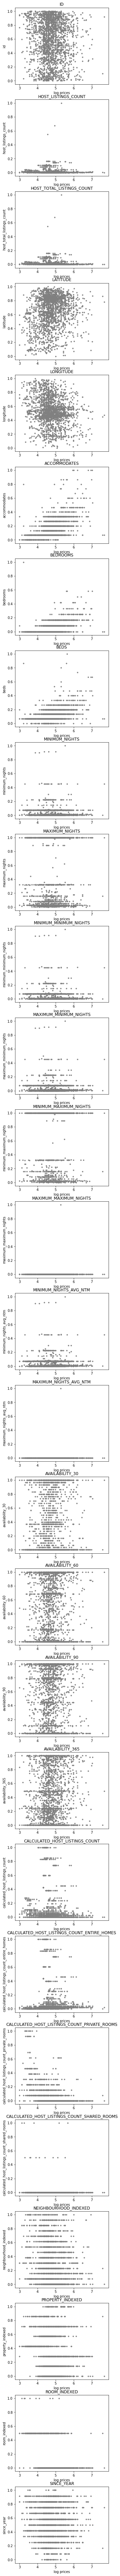

In [37]:
plottable = 0

for col in df.columns:
    _type = df.schema[col].dataType.typeName()
    if (_type == 'double' or _type == 'integer') and (col != 'price'):
        plottable += 1
        
plt.rcParams['figure.figsize'] = [5, 5 * plottable]

current = 0
for col in df.columns:
    _type = df.schema[col].dataType.typeName()
    if (_type == 'double' or _type == 'integer') \
      and (col != 'price') and (col != 'log_price'):
        current += 1
        plt.subplot(plottable, 1, current)
        
        pairs = list()       
        for p in df.select("log_price", col).toLocalIterator():
            pairs.append( (p['log_price'], p[col]) )
        pairs = sorted(pairs, key=lambda t:t[0])
        vals = [ t[1] for t in pairs if t[1] is not None ]
        minv = min(vals)
        maxv = max(vals)
        if minv != maxv:
            vals = list(map(lambda x: x if x is None else (x-minv)/(maxv-minv), vals))
        logp = [ t[0] for t in pairs if t[1] is not None ]
            
        plt.plot(logp, vals, '.', color='gray')
        
        plt.xlabel('log prices')
        plt.ylabel(col)
        plt.title(col.upper())

plt.savefig("eda.png", bbox_inches='tight', dpi=300)
plt

For categorical data, we can plot box plots for each of the prices

<module 'matplotlib.pyplot' from '/vol/scratch/virtualenv/tourism/lib/python3.7/site-packages/matplotlib/pyplot.py'>

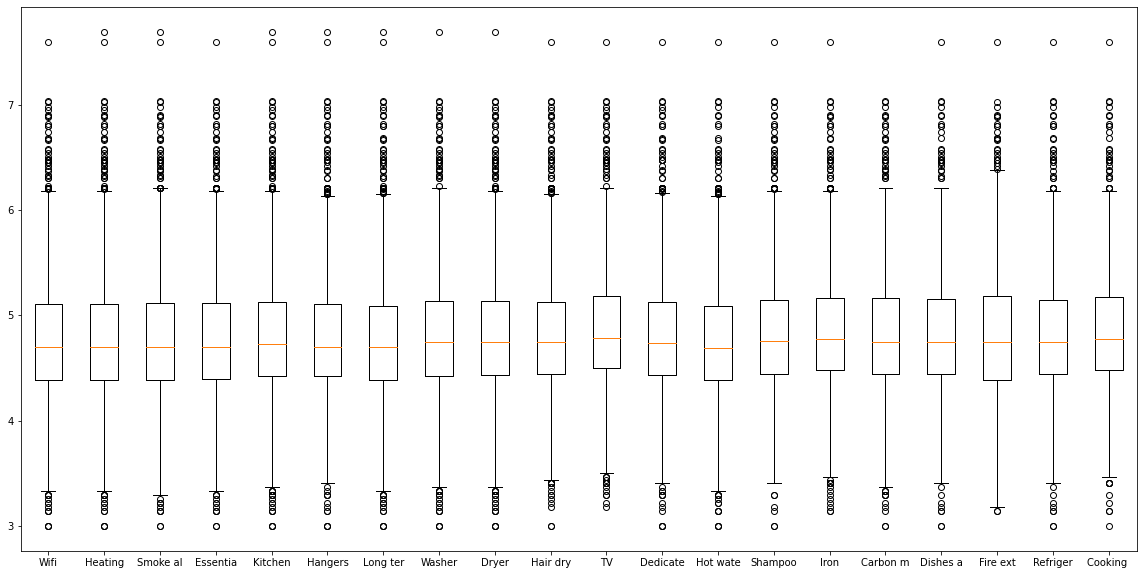

In [38]:
amenities_prices = [ list()  for a in fitted_amenities.vocabulary ] 
for r in df.select("amenities_vector", "log_price").toLocalIterator():
    for idx in r[0].indices:
        amenities_prices[idx].append(r[1])
        
labels = [ label[:8] for label in fitted_amenities.vocabulary ]
        
plt.rcParams['figure.figsize'] = [20, 10]
plt.boxplot(amenities_prices, labels=labels)
plt

Having a TV pays better on average? Who would have thought.

<module 'matplotlib.pyplot' from '/vol/scratch/virtualenv/tourism/lib/python3.7/site-packages/matplotlib/pyplot.py'>

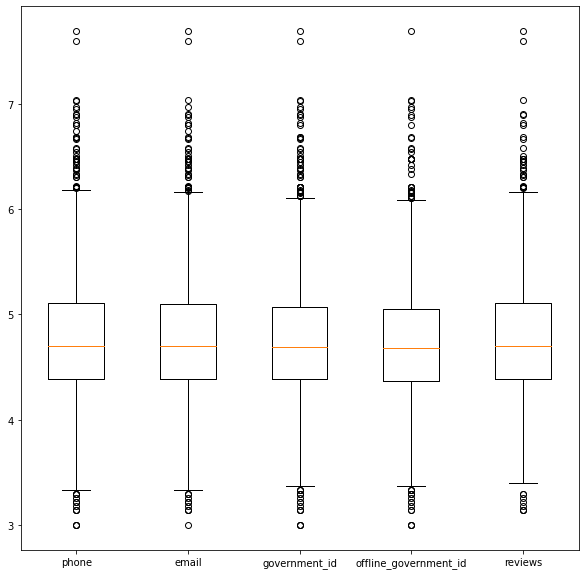

In [39]:
verification_prices = [ list()  for a in fitted_verifications.vocabulary ] 
for r in df.select("verifications_vector", "log_price").toLocalIterator():
    for idx in r[0].indices:
        verification_prices[idx].append(r[1])
        
plt.rcParams['figure.figsize'] = [10, 10]
plt.boxplot(verification_prices, labels=fitted_verifications.vocabulary)
plt

No noticeable difference.

<module 'matplotlib.pyplot' from '/vol/scratch/virtualenv/tourism/lib/python3.7/site-packages/matplotlib/pyplot.py'>

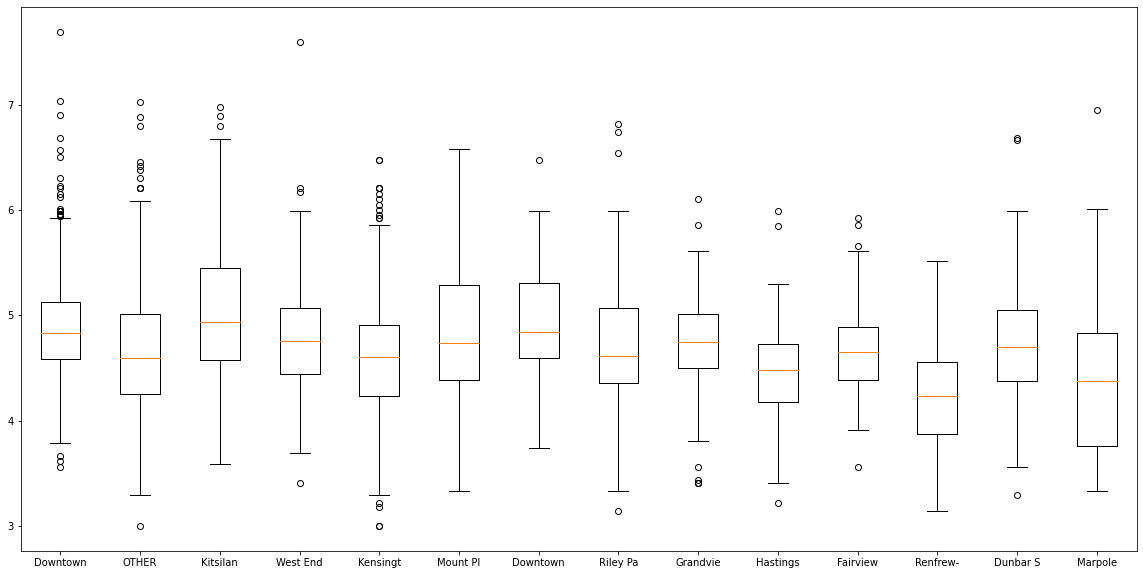

In [40]:
n_prices = [ list()  for a in fitted_n_indexer.labels ] 
for r in df.select("neighbourhood_indexed", "log_price").toLocalIterator():
    n_prices[int(r[0])].append(r[1])
        
labels = [ label[:8] for label in fitted_n_indexer.labels ]
        
plt.rcParams['figure.figsize'] = [20, 10]
plt.boxplot(n_prices, labels=labels)
plt

From here, the following features look good:

* host_since
* host_listings_count
* host_total_listings_count
* accommodates
* bedrooms
* beds
* minimum_nights
* maximum_nights
* minimum_minimum_nights
* maximum_minimum_nights
* minimum_nights_avg_ntm
* availability_30
* availability_60
* availability_90
* availability_365
* calculated_host_listings_count
* calculated_host_listings_count_entire_homes
* calculated_host_listings_count_private_rooms
* neighbourhood_indexed
* property_type_indexed
* room_type_indexed

But ```availability``` cannot be computed for new properties, so we will not use it. Similarly with ```since_years```.

In [41]:
columns = [ "host_listings_count", "host_total_listings_count", "accommodates", 
            "bedrooms", "beds", "minimum_nights", "maximum_nights", "minimum_minimum_nights", 
            "maximum_minimum_nights", "minimum_nights_avg_ntm",
            "calculated_host_listings_count", 
            "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", 
            "neighbourhood_indexed", "property_indexed", "room_indexed" ]

## Imputation

Finally, we need to deal with undefined values for each of the selected columns. We will replace them with the *mode*, the most common value for that column.

In [42]:
modes = { c: df.groupBy(c).\
  count().\
  sort("count", ascending=False).head()[c] for c in columns }
modes

{'host_listings_count': 1,
 'host_total_listings_count': 1,
 'accommodates': 2,
 'bedrooms': 1,
 'beds': 1,
 'minimum_nights': 30,
 'maximum_nights': 1125,
 'minimum_minimum_nights': 30,
 'maximum_minimum_nights': 30,
 'minimum_nights_avg_ntm': 30.0,
 'calculated_host_listings_count': 1,
 'calculated_host_listings_count_entire_homes': 1,
 'calculated_host_listings_count_private_rooms': 0,
 'neighbourhood_indexed': 0.0,
 'property_indexed': 0.0,
 'room_indexed': 0.0}

We can verify the code works as intended because the indexed columns return 0.0, as expected. We are now ready to impute. We will separate the imputers by type (integer vs. dobule).

In [43]:
class Imputer(UnaryTransformer):
    
    def __init__(self, value, outType):
        super(UnaryTransformer, self).__init__()
        self.value = value
        self.outType = outType
    
    def createTransformFunc(self):
        return lambda x: self.value if x is None else x
    
    def outputDataType(self):
        return self.outType

    def validateInputType(self, inputType):
        assert inputType == self.outType, f'Expected {outType.typeName()} and found {inputType}'
        
imp_columns = list()
for c in columns:
    c_imp = c + "_imp"
    imp_columns.append(c_imp)
    imputer = Imputer(modes[c], df.schema[c].dataType).\
      setInputCol(c). \
      setOutputCol(c_imp)
    stages.append(imputer)

Now we re-execute the full-pipeline to obtain the imputed values.

In [44]:
pipeline = Pipeline(stages=stages)
df = pipeline.fit(dataset).transform(dataset)

In [45]:
print("base")
for c in columns:
    print(" ",c, df.schema[c].dataType.typeName(), df.filter(c + " is null").count())
print("imputed")
for c in imp_columns:
    print(" ",c, df.schema[c].dataType.typeName(), df.filter(c + " is null").count())
print("amenities_vector", df.filter("amenities_vector is null").count())

base
  host_listings_count integer 1
  host_total_listings_count integer 1
  accommodates integer 0
  bedrooms integer 151
  beds integer 20
  minimum_nights integer 0
  maximum_nights integer 0
  minimum_minimum_nights integer 0
  maximum_minimum_nights integer 0
  minimum_nights_avg_ntm double 0
  calculated_host_listings_count integer 0
  calculated_host_listings_count_entire_homes integer 0
  calculated_host_listings_count_private_rooms integer 0
  neighbourhood_indexed double 0
  property_indexed double 0
  room_indexed double 0
imputed
  host_listings_count_imp integer 0
  host_total_listings_count_imp integer 0
  accommodates_imp integer 0
  bedrooms_imp integer 0
  beds_imp integer 0
  minimum_nights_imp integer 0
  maximum_nights_imp integer 0
  minimum_minimum_nights_imp integer 0
  maximum_minimum_nights_imp integer 0
  minimum_nights_avg_ntm_imp double 0
  calculated_host_listings_count_imp integer 0
  calculated_host_listings_count_entire_homes_imp integer 0
  calculated_h

We can see all columns have been correctly imputed.

In [46]:
df.count()

2167

In [47]:
assembler = VectorAssembler(
    inputCols=imp_columns + ["amenities_vector"],
    outputCol="features", handleInvalid="error")

output = assembler.transform(df)
output.count()

2167

In [48]:
len(next(output.toLocalIterator())['features'])

36

In [49]:
next(output.toLocalIterator())['features']

DenseVector([1.0, 1.0, 2.0, 1.0, 1.0, 30.0, 60.0, 30.0, 30.0, 30.0, 1.0, 1.0, 0.0, 3.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0])

In [50]:
rf = RandomForestRegressor(featuresCol="features", labelCol='log_price', seed=42)

model = rf.fit(output)

In [51]:
pipeline = Pipeline(stages=stages + [assembler])
df_devset = pipeline.fit(dataset).transform(devset)

predictions = model.transform(df_devset)

predictions.select("features","log_price", "prediction").show(5)

+--------------------+------------------+-----------------+
|            features|         log_price|       prediction|
+--------------------+------------------+-----------------+
|[49.0,49.0,5.0,2....|5.0106352940962555|5.111937128072566|
|[1.0,1.0,4.0,1.0,...| 5.293304824724492|4.783042564532028|
|[5.0,5.0,6.0,3.0,...| 5.501258210544727|5.281162445096307|
|[1.0,1.0,2.0,1.0,...| 5.225746673713202|4.725892380368114|
|[1.0,1.0,2.0,1.0,...| 4.852030263919617|4.628450415150274|
+--------------------+------------------+-----------------+
only showing top 5 rows



In [52]:
metrics = RegressionMetrics(predictions.select("prediction", "log_price").rdd\
                            .map(lambda r: (math.exp(r['prediction']), math.exp(r['log_price']))))

In [53]:
baseError = metrics.meanAbsoluteError
baseError

56.83296858469796

In [54]:
print("Average price", sum(map(lambda x:x['price'],
                               df_devset.select("price").toLocalIterator())) / df_devset.count())
prices = [ p['price'] for p in df_devset.select("price").toLocalIterator() ]
prices = sorted(prices)
print("Median price", prices[len(prices)// 2])

Average price 150.7699704142012
Median price 115


So the current model put us about 50 dollars from the actual price, which is an error between 30% to 50% of the actual price. It is a poor model, but it is a start. Let us see which features are better.

## Error Analysis

Let us reassemble the labels for our feature vector.

In [55]:
labels = columns + list(map(lambda x: "amenity: " + x, fitted_amenities.vocabulary))
labels

['host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_nights_avg_ntm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'neighbourhood_indexed',
 'property_indexed',
 'room_indexed',
 'amenity: Wifi',
 'amenity: Heating',
 'amenity: Smoke alarm',
 'amenity: Essentials',
 'amenity: Kitchen',
 'amenity: Hangers',
 'amenity: Long term stays allowed',
 'amenity: Washer',
 'amenity: Dryer',
 'amenity: Hair dryer',
 'amenity: TV',
 'amenity: Dedicated workspace',
 'amenity: Hot water',
 'amenity: Shampoo',
 'amenity: Iron',
 'amenity: Carbon monoxide alarm',
 'amenity: Dishes and silverware',
 'amenity: Fire extinguisher',
 'amenity: Refrigerator',
 'amenity: Cooking basics']

We can now check the random forest feature importance.

In [56]:
importances = [ (model.featureImportances[idx], lbl) for idx, lbl in enumerate(labels) ]
table = '<table><tr><th>Rank</th><th>Feature</th><th>Importance</th></tr>'
for idx, pair in enumerate(sorted(importances, reverse=True)):
    score, lbl =  pair
    table = '{}<tr><td>{}</td><td>{}</td><td style="text-align: left">{}</td></tr>'.format(table, idx + 1, lbl, score)
table += '</table>'    
display(HTML(table))

We can see that many amenities are not important for price prediction. It might be because they are expected amenities (like "Dishes and silverware") or not important for the type of tourism received by Vancouver (e.g., "Dedicated workspace").

## Feature selection: dropping amenities

We can keep the only two amenities that seem to matter: TV and Wifi by dropping the processing of amenities as StringIndexer and CountVectorizer and instead using a spotter, checking whether the original amenities string contains "TV" and "Wifi" to produce the two binary features.

It is also a good moment to clean the pipeline.

In [57]:
for idx, stage in enumerate(stages):
    print(idx, stage)

0 SetReducer_be1cd06abde5
1 SetReducer_1553fba51e0c
2 SetReducer_1a1f72ec4e63
3 StringIndexerModel: uid=StringIndexer_ee4a421f98bb, handleInvalid=error
4 StringIndexerModel: uid=StringIndexer_65923eaf74ab, handleInvalid=error
5 StringIndexerModel: uid=StringIndexer_41256a6da518, handleInvalid=error
6 FieldSplitter_9d732ace06c1
7 FieldSplitter_071896664d79
8 CountVectorizerModel: uid=CountVectorizer_6c0c861e16c7, vocabularySize=20
9 CountVectorizerModel: uid=CountVectorizer_7f37b47c4a36, vocabularySize=5
10 YearKeeper_44fe8355dd7e
11 LogTransformer_1ed73acf9ec7
12 Imputer_64cfe6164b2c
13 Imputer_cf0bd26a84de
14 Imputer_7f5907f4048f
15 Imputer_32bf93c9bbe9
16 Imputer_f8e3a806c6f5
17 Imputer_9e9a37076a45
18 Imputer_2d735b3489a3
19 Imputer_38e7adab229b
20 Imputer_adc3d2523088
21 Imputer_6f7dd177fa52
22 Imputer_bf8d9571070c
23 Imputer_f578f1561c41
24 Imputer_6e651794eb6b
25 Imputer_8d9ee1f455d7
26 Imputer_1f39c4d33256
27 Imputer_752707a53b3d


In [58]:
new_stages = stages[0:6] + stages[11:]
for idx, stage in enumerate(new_stages):
    print(idx, stage)

0 SetReducer_be1cd06abde5
1 SetReducer_1553fba51e0c
2 SetReducer_1a1f72ec4e63
3 StringIndexerModel: uid=StringIndexer_ee4a421f98bb, handleInvalid=error
4 StringIndexerModel: uid=StringIndexer_65923eaf74ab, handleInvalid=error
5 StringIndexerModel: uid=StringIndexer_41256a6da518, handleInvalid=error
6 LogTransformer_1ed73acf9ec7
7 Imputer_64cfe6164b2c
8 Imputer_cf0bd26a84de
9 Imputer_7f5907f4048f
10 Imputer_32bf93c9bbe9
11 Imputer_f8e3a806c6f5
12 Imputer_9e9a37076a45
13 Imputer_2d735b3489a3
14 Imputer_38e7adab229b
15 Imputer_adc3d2523088
16 Imputer_6f7dd177fa52
17 Imputer_bf8d9571070c
18 Imputer_f578f1561c41
19 Imputer_6e651794eb6b
20 Imputer_8d9ee1f455d7
21 Imputer_1f39c4d33256
22 Imputer_752707a53b3d


In [59]:
class AmenitySpotter(UnaryTransformer):
    def __init__(self, amenity):
        super(UnaryTransformer, self).__init__()
        self.amenity = amenity

    def createTransformFunc(self):
        return lambda x: self.amenity in x
    
    def outputDataType(self):
        return BooleanType()

    def validateInputType(self, inputType):
        assert inputType == StringType(), f'Expected StringType() and found {inputType}'
        
tv_spotter = AmenitySpotter("TV").\
  setInputCol("amenities"). \
  setOutputCol("has_tv")
wifi_spotter = AmenitySpotter("Wifi").\
  setInputCol("amenities"). \
  setOutputCol("has_wifi")
new_stages.append(tv_spotter)
new_stages.append(wifi_spotter)

tv_spotter.transform(df).show(vertical=True,truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                               | 13358                                                                                      

In [60]:
assembler = VectorAssembler(
    inputCols=imp_columns + ["has_tv", "has_wifi"],
    outputCol="features", handleInvalid="error")

pipeline = Pipeline(stages=new_stages + [assembler]).fit(dataset)
df = pipeline.transform(dataset)

rf = RandomForestRegressor(featuresCol="features", labelCol='log_price', seed=42)
model = rf.fit(df)

df_devset = pipeline.transform(devset)
predictions = model.transform(df_devset)

predictions.select("features","log_price", "prediction").show(5)

metrics = RegressionMetrics(predictions.select("prediction", "log_price").rdd\
                            .map(lambda r: (math.exp(r['prediction']), math.exp(r['log_price']))))

print("base:", baseError)
selectedError = metrics.meanAbsoluteError
selectedError

+--------------------+------------------+-----------------+
|            features|         log_price|       prediction|
+--------------------+------------------+-----------------+
|[49.0,49.0,5.0,2....|5.0106352940962555|5.060099291695992|
|[1.0,1.0,4.0,1.0,...| 5.293304824724492|4.865733059150112|
|[5.0,5.0,6.0,3.0,...| 5.501258210544727|5.348326732154461|
|[1.0,1.0,2.0,1.0,...| 5.225746673713202|4.724549844833268|
|[1.0,1.0,2.0,1.0,...| 4.852030263919617|4.604958242838359|
+--------------------+------------------+-----------------+
only showing top 5 rows

base: 56.83296858469796


57.18225268896161

That didn't work that well. Random forests are very robust, so there is no boost in the signal by dropping the amenities.

Let us take a look at the feature importance again.

In [61]:
labels = columns + ["has_tv", "has_wifi"]

importances = [ (model.featureImportances[idx], lbl) for idx, lbl in enumerate(labels) ]
table = '<table><tr><th>Rank</th><th>Feature</th><th>Importance</th></tr>'
for idx, pair in enumerate(sorted(importances, reverse=True)):
    score, lbl = pair
    table = '{}<tr><td>{}</td><td>{}</td><td style="text-align: left">{}</td></tr>'.format(table, idx+1, lbl, score)
table += '</table>'    
display(HTML(table))

Now, the neighbourhood where a property resides seems to be as important as having Wifi. This is intuitively wrong but we know most of our training properties are downtown. It is possible the neighbourhood is not being as useful as we would like because the value of a location is regarding its distance, for example to SkyTrain stations (Vancouver's elevated subway alternative).

## Expanding using external data: SkyTrain stations

For that, we will have to go back to the latitude and longitude columns in the raw data and compute a rough aproximation of the distance to the closest SkyTrain station for them, using [OpenStreet map data](https://wiki.openstreetmap.org/wiki/Vancouver_SkyTrain).

In [62]:
stops = list()
with open("stops.tsv") as s:
    for row in s:
        stops.append(tuple(map(float,row.split("\t"))))
stops           

[(49.2591619, -122.9639466),
 (49.2533813, -122.9181633),
 (49.2484049, -122.8968898),
 (49.1895232, -122.847929),
 (49.1827396, -122.84468),
 (49.2297489, -123.0127361),
 (49.2483091, -123.0559279),
 (49.2441271, -123.045876),
 (49.2257767, -123.0038962),
 (49.2200544, -122.9885247),
 (49.2121895, -122.9593092),
 (49.2000809, -122.9488866),
 (49.2013864, -122.9126807),
 (49.2047284, -122.9062802),
 (49.2534613, -122.918123),
 (49.2793597, -123.1093495),
 (49.2861459, -123.1120211),
 (49.2484747, -122.8968053),
 (49.2618723, -123.069195),
 (49.2629063, -123.0685311),
 (49.2649587, -123.013462),
 (49.1956136, -123.1260625),
 (49.1967024, -123.1464206),
 (49.1839068, -123.136362),
 (49.1747215, -123.1365025),
 (49.2611963, -122.8901154),
 (49.1930946, -123.1579202),
 (49.2043891, -122.8741208),
 (49.224476, -122.8895687),
 (49.2384152, -123.0319039),
 (49.2657805, -123.078985),
 (49.2730906, -123.1003413),
 (49.2333355, -122.8827927),
 (49.2545929, -122.9390127),
 (49.2647152, -122.98211

In [63]:
gps_point = VectorAssembler(inputCols=["latitude", "longitude" ], outputCol="gps")
stages.append(gps_point)

In [64]:
gps_point.transform(df).show(truncate=False,vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                               | 13358                                                                                      

Now we can calculate the distance to the closest SkyTrain station. To get more accurate results, the curvature of the earth needs to be taken into account using a GIS library to compute distances. We will ignore this issue in this example. That means that differences in longitude will be stronger than differences in latitude, as Vancouver is rather North.

In [65]:
class SkyTrainDistance(UnaryTransformer):
    def __init__(self, stops):
        super(UnaryTransformer, self).__init__()
        self.stops = stops

    def createTransformFunc(self):
        def closest(x):
            latx = float(x[0])
            longx = float(x[1])
            closest_dist = None
            for lat, long in self.stops:
                dist = (latx-lat)**2 + (longx-long)**2
                if closest_dist is None or dist < closest_dist:
                    closest_dist = dist
            return closest_dist
        return closest
    
    def outputDataType(self):
        return DoubleType()

    def validateInputType(self, inputType):
        assert inputType == VectorUDT(), f'Expected VectorUDT() and found {inputType}'

skytrainer = SkyTrainDistance(stops).\
  setInputCol("gps"). \
  setOutputCol("sky_distance")
stages.append(skytrainer)

In [66]:
pipeline = Pipeline(stages=stages)
df = pipeline.fit(dataset).transform(dataset)

df.show(vertical=True,truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                                               | 13358                                                                                      

<module 'matplotlib.pyplot' from '/vol/scratch/virtualenv/tourism/lib/python3.7/site-packages/matplotlib/pyplot.py'>

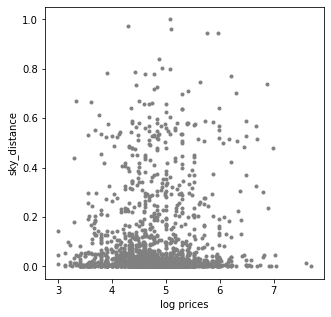

In [67]:
plt.rcParams['figure.figsize'] = [5, 5]
pairs = list()
        
for p in df.select("log_price", "sky_distance").toLocalIterator():
    pairs.append( (p['log_price'], p["sky_distance"]) )
pairs = sorted(pairs, key=lambda t:t[0])
vals = [ t[1] for t in pairs if t[1] is not None ]
minv = min(vals)
maxv = max(vals)
if minv != maxv:
    vals = list(map(lambda x: x if x is None else (x-minv)/(maxv-minv), vals))
logp = [ t[0] for t in pairs if t[1] is not None ]
            
plt.plot(logp, vals, '.', color='gray')
        
plt.xlabel('log prices')
plt.ylabel("sky_distance")
plt

Doesn't look too peachy, let us see if the Random Forest can do something combining it with other features.

In [68]:
assembler = VectorAssembler(
    inputCols=imp_columns + ["amenities_vector", "sky_distance"],
    outputCol="features", handleInvalid="error")

pipeline = Pipeline(stages=stages + [assembler]).fit(dataset)
df = pipeline.transform(dataset)

rf = RandomForestRegressor(featuresCol="features", labelCol='log_price', seed=42)
model = rf.fit(df)

df_devset = pipeline.transform(devset)
predictions = model.transform(df_devset)

predictions.select("features","log_price", "prediction").show(5)

metrics = RegressionMetrics(predictions.select("prediction", "log_price").rdd\
                            .map(lambda r: (math.exp(r['prediction']), math.exp(r['log_price']))))

skyError = metrics.meanAbsoluteError
print("base:", baseError)
print("selected:", selectedError)
skyError

+--------------------+------------------+-----------------+
|            features|         log_price|       prediction|
+--------------------+------------------+-----------------+
|[49.0,49.0,5.0,2....|5.0106352940962555|5.013525997312197|
|[1.0,1.0,4.0,1.0,...| 5.293304824724492| 4.85490285833901|
|[5.0,5.0,6.0,3.0,...| 5.501258210544727| 5.25627305221444|
|[1.0,1.0,2.0,1.0,...| 5.225746673713202|4.729864780112891|
|[1.0,1.0,2.0,1.0,...| 4.852030263919617|4.571939227455491|
+--------------------+------------------+-----------------+
only showing top 5 rows

base: 56.83296858469796
selected: 57.18225268896161


55.96113276013822

This reduced the error by almost one dollar. It seems a step in the right direction.

In [69]:
labels = columns + fitted_amenities.vocabulary + ["sky_distance"]

importances = [ (model.featureImportances[idx], lbl) for idx, lbl in enumerate(labels) ]
table = '<table><tr><th>Rank</th><th>Feature</th><th>Importance</th></tr>'
for idx, pair in enumerate(sorted(importances, reverse=True)):
    score, lbl = pair
    table = '{}<tr><td>{}</td><td>{}</td><td style="text-align: left">{}</td></tr>'.format(table, idx+1, lbl, score)
table += '</table>'    
display(HTML(table))

The new feature is more important than neighbourhood. To conclude, we can do a drill-down on the instances with highest absolute error using SHAP values. We first initialize a SHAP explainer using our model.

In [70]:
import shap
import numpy as np

explainer = shap.TreeExplainer(model)

We now identify some rows that contribute the most to the absolute error.

In [71]:
test_features = np.array(predictions.select("features").collect())
pred_actual = predictions.select("log_price", "prediction", "price").collect()
abs_err = list(map(lambda x:abs(x[0] - x[1]), pred_actual))

In [72]:
abs_err = list(map(lambda t:(t[1], t[0]), enumerate(abs_err)))
abs_err = sorted(abs_err, reverse=True)
abs_err[:10]

[(3.3246071806661863, 862),
 (2.8965173585297146, 1312),
 (1.79262901646341, 664),
 (1.7715506281028377, 754),
 (1.6875898593949783, 695),
 (1.5658884091267078, 551),
 (1.5656351380182016, 995),
 (1.4835914017434364, 311),
 (1.4788509033722352, 1062),
 (1.4699892689246497, 649)]

In [73]:
shap.initjs()
err, idx = abs_err[0]
row_data = test_features[idx].reshape(-1)
print("Expected / prediction", pred_actual[idx], "err", err, "price", pred_actual[idx]["price"], "predicted", math.exp(pred_actual[idx][1]))
shap_values = explainer.shap_values(row_data, check_additivity=False)
print(devset.take(idx+1)[-1])
shap.force_plot(explainer.expected_value[0], shap_values, row_data, feature_names=labels)

Expected / prediction Row(log_price=8.086410275323782, prediction=4.761803094657596, price=3250) err 3.3246071806661863 price 3250 predicted 116.95661974766784
Row(id=37181228, host_since='2019/05/18', host_location='Surrey, British Columbia, Canada', host_response_time='N/A', host_response_rate='N/A', host_acceptance_rate='N/A', host_is_superhost='f', host_neighbourhood='Downtown Vancouver', host_listings_count=0, host_total_listings_count=0, host_verifications="['email', 'phone']", host_has_profile_pic='t', host_identity_verified='f', neighbourhood='Vancouver, British Columbia, Canada', neighbourhood_cleansed='Downtown', neighbourhood_group_cleansed=None, latitude=49.27673, longitude=-123.12571, property_type='Entire apartment', room_type='Entire home/apt', accommodates=2, bathrooms=None, bathrooms_text='1 bath', bedrooms=1, beds=1, amenities="['Kitchen', 'Hot tub', 'Private entrance', 'Pool', 'Elevator', 'Gym', 'Hangers', 'Smoke alarm', 'Wifi', 'Essentials', 'Heating', 'Washer', 'Dr

Well, that listing is new and the host made a mistake pricing it per month (or multiple months) while AirBnB is daily. The price set as $3,250 a night is meaningless. Let's look at the second entry.

In [74]:
shap.initjs()
err, idx = abs_err[1]
row_data = test_features[idx].reshape(-1)
print("Expected / prediction", pred_actual[idx], "err", err, "price", pred_actual[idx]["price"], "predicted", math.exp(pred_actual[idx][1]))
shap_values = explainer.shap_values(row_data, check_additivity=False)
print(devset.take(idx+1)[-1])
shap.force_plot(explainer.expected_value[0], shap_values, row_data, feature_names=labels)

Expected / prediction Row(log_price=6.856461984594587, prediction=3.959944626064872, price=950) err 2.8965173585297146 price 950 predicted 52.45442126095771
Row(id=47405647, host_since='2020/10/06', host_location='Vancouver, British Columbia, Canada', host_response_time='N/A', host_response_rate='N/A', host_acceptance_rate='N/A', host_is_superhost='f', host_neighbourhood=None, host_listings_count=4, host_total_listings_count=4, host_verifications="['email', 'phone', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']", host_has_profile_pic='t', host_identity_verified='t', neighbourhood=None, neighbourhood_cleansed='Renfrew-Collingwood', neighbourhood_group_cleansed=None, latitude=49.24738, longitude=-123.02397, property_type='Private room in townhouse', room_type='Private room', accommodates=1, bathrooms=None, bathrooms_text='Shared half-bath', bedrooms=None, beds=1, amenities="['Kitchen', 'Hot tub', 'Iron', 'Private entrance', 'Lock on bedroom door', 'Indoor firepla

Same error here, $950 seems to be the price per month because the minimum stay is 30 days. Again, a new listing.

In [75]:
shap.initjs()
err, idx = abs_err[2]
row_data = test_features[idx].reshape(-1)
print("Expected / prediction", pred_actual[idx], "err", err, "price", pred_actual[idx]["price"], "predicted", math.exp(pred_actual[idx][1]))
shap_values = explainer.shap_values(row_data, check_additivity=False)
print(devset.take(idx+1)[-1])
shap.force_plot(explainer.expected_value[0], shap_values, row_data, feature_names=labels)

Expected / prediction Row(log_price=6.902742737158593, prediction=5.110113720695183, price=995) err 1.79262901646341 price 995 predicted 165.68919609295506
Row(id=30352025, host_since='2016/07/26', host_location='West Vancouver, British Columbia, Canada', host_response_time='N/A', host_response_rate='N/A', host_acceptance_rate='N/A', host_is_superhost='f', host_neighbourhood='Fairview', host_listings_count=1, host_total_listings_count=1, host_verifications="['phone', 'facebook', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']", host_has_profile_pic='t', host_identity_verified='t', neighbourhood=None, neighbourhood_cleansed='Fairview', neighbourhood_group_cleansed=None, latitude=49.26657, longitude=-123.13922, property_type='Entire condominium', room_type='Entire home/apt', accommodates=6, bathrooms=None, bathrooms_text='3 baths', bedrooms=2, beds=3, amenities="['Hot tub', 'Kitchen', 'First aid kit', 'Hangers', 'Wifi', 'Breakfast', 'Essentials', 'Heating'

This is an entire house that accommodates 6 people. Going back to the source data, it is described as a "luxury condo with an outdoor hot tub". We can see the neighborhoud and distance to skytrain went against the pricing but the description says it is very close to Granville Island and its shops and restaurants. Adding more POIs (points-of-interest) should help here. And of course, NLP on the descriptions.

Where to go from here? An obvious expansion is to download POIs ("points-of-interest") from OpenStreetMap and add a feature of the number of POIs within 1Km radius. Another interesting feature is the distance to the closest SkyTrain station of the [Canada Line](https://www.translink.ca/schedules-and-maps/skytrain#canada-line) that connects the city directly to the airport. We can surmise that a direct airport connection might command higher prices.

Finally, it might be possible to train two different models, one for downtown, another for the rest of the city and use them to predict a price, then leave it to the final model to use that information for the final prediction.